# ALL CEDAR
## 2-ways n-shots

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install keras

In [3]:
import numpy as np
import os
import cv2
import itertools
import random

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Lambda, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K


import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim

In [4]:
# All the images will be converted to the same size before processing
img_h, img_w = 120, 120

def preprocess_image(img_path):
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale

    # Check if the image is empty or None
    if image is None or len(image) == 0:
        print(f"Error: Image {img_path} is empty or None.")
        return None

    # Check if the image has valid dimensions
    if image.shape[0] == 0 or image.shape[1] == 0:
        print(f"Error: Image {img_path} has invalid dimensions.")
        return None

    image = cv2.resize(image, (img_h, img_w))  # Resize image
    image = image.astype('float32') / 255.0  # Normalize pixel values
    return image.reshape((img_h, img_w, 1))  # Reshape to (img_h, img_w, 1)

# Function to generate batches
def generate_batch(orig_groups, forg_groups, batch_size=32):
    while True:
        pairs = [np.zeros((batch_size, img_h, img_w, 1)) for _ in range(2)]
        targets = np.zeros((batch_size,))

        for i in range(batch_size):
            if i < batch_size // 2:
                # Genuine-Genuine pairs
                pair_idx = np.random.randint(len(orig_groups), size=2)
                pair = (np.random.choice(orig_groups[pair_idx[0]]), np.random.choice(orig_groups[pair_idx[1]]))
                targets[i] = 1
            else:
                # Genuine-Forged pairs
                orig_idx = np.random.randint(len(orig_groups))
                orig = np.random.choice(orig_groups[orig_idx])
                forg = np.random.choice(forg_groups[orig_idx])
                pair = (orig, forg)
                targets[i] = 0

            # Preprocess images using preprocess_image function
            img1 = preprocess_image(pair[0])
            img2 = preprocess_image(pair[1])

            # Assign preprocessed images to pairs
            pairs[0][i, :, :, :] = img1
            pairs[1][i, :, :, :] = img2

        yield pairs, targets

# Load and preprocess data
path = "/content/drive/MyDrive/Multilingual dataset/CEDAR"
dir_list = next(os.walk(path))[1]

orig_groups, forg_groups = [], []
for directory in dir_list:
    images = os.listdir(os.path.join(path, directory))
    images.sort()
    images = [os.path.join(path, directory, x) for x in images]
    forg_groups.append(images[:24])
    orig_groups.append(images[24:])

# Split data into train, validation, and test sets
orig_train, orig_val_test, forg_train, forg_val_test = train_test_split(orig_groups, forg_groups, test_size=0.2, random_state=42)
orig_val, orig_test, forg_val, forg_test = train_test_split(orig_val_test, forg_val_test, test_size=0.5, random_state=42)

# Define Siamese network model
def get_siamese_model(input_shape):
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    base_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),  # Add Flatten layer to flatten the output
        Dense(256, activation='relu')
    ])

    processed_a = base_model(input_a)
    processed_b = base_model(input_b)

    distance = Lambda(lambda x: tf.abs(x[0] - x[1]))([processed_a, processed_b])

    output = Dense(1, activation='sigmoid')(distance)

    model = Model(inputs=[input_a, input_b], outputs=output)
    return model

# Define batch size and generators
batch_size = 32
train_batch_generator = generate_batch(orig_train, forg_train, batch_size=batch_size)
val_batch_generator = generate_batch(orig_val_test, forg_val_test, batch_size=batch_size)
test_batch_generator = generate_batch(orig_test, forg_test, batch_size=batch_size)

# Compile model
input_shape = (img_h, img_w, 1)
model = get_siamese_model(input_shape)
model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08))

# Define callbacks
callbacks = [
    EarlyStopping(patience=4, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/Multilingual dataset/Weights/all-data-weights/cedar-{epoch:03d}.h5',
                    verbose=1, save_best_only=True, save_weights_only=True)
]

# Train model
num_train_samples = sum(len(group) for group in orig_train + forg_train)
num_val_samples = sum(len(group) for group in orig_val_test + forg_val_test)
batches_per_epoch_train = num_train_samples // batch_size
batches_per_epoch_val = num_val_samples // batch_size

# Calculate steps per epoch
steps_per_epoch_train = max(1, num_train_samples // batch_size)
steps_per_epoch_val = max(1, num_val_samples // batch_size)

results = model.fit(
    train_batch_generator,
    steps_per_epoch=steps_per_epoch_train,  # Use calculated steps per epoch
    epochs=5,
    validation_data=val_batch_generator,
    validation_steps=steps_per_epoch_val,  # Use calculated steps per epoch for validation
    callbacks=callbacks
)

Epoch 1/5
66/66 [==============================] - ETA: 0s - loss: 0.5953
Epoch 1: val_loss improved from inf to 0.52144, saving model to /content/drive/MyDrive/Multilingual dataset/Weights/all-data-weights/cedar-001.h5
66/66 [==============================] - 199s 3s/step - loss: 0.5953 - val_loss: 0.5214 - lr: 1.0000e-04
Epoch 2/5
66/66 [==============================] - ETA: 0s - loss: 0.5269
Epoch 2: val_loss improved from 0.52144 to 0.51196, saving model to /content/drive/MyDrive/Multilingual dataset/Weights/all-data-weights/cedar-002.h5
66/66 [==============================] - 181s 3s/step - loss: 0.5269 - val_loss: 0.5120 - lr: 1.0000e-04
Epoch 3/5
66/66 [==============================] - ETA: 0s - loss: 0.5224
Epoch 3: val_loss improved from 0.51196 to 0.50262, saving model to /content/drive/MyDrive/Multilingual dataset/Weights/all-data-weights/cedar-003.h5
66/66 [==============================] - 175s 3s/step - loss: 0.5224 - val_loss: 0.5026 - lr: 1.0000e-04
Epoch 4/5
66/66 [

In [5]:
# Load best weights
model.load_weights('/content/drive/MyDrive/Multilingual dataset/Weights/all-data-weights/cedar-005.h5')

In [15]:
# Test model
test_batch_inputs, test_batch_labels = next(test_batch_generator)
predictions = model.predict(test_batch_inputs)

# Function to compute ROC curve
def compute_roc_curve(predictions, labels):
    fpr, tpr, thresholds = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, thresholds, roc_auc

# Compute ROC curve
fpr, tpr, thresholds, roc_auc = compute_roc_curve(predictions, test_batch_labels)

# Find the optimal threshold using Youden's J statistic
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Apply the optimal threshold to predictions
predictions_binary = (predictions > optimal_threshold).astype(int)

# Calculate metrics using the optimal threshold
accuracy = accuracy_score(test_batch_labels, predictions_binary)
precision = precision_score(test_batch_labels, predictions_binary)
recall = recall_score(test_batch_labels, predictions_binary)
f1 = f1_score(test_batch_labels, predictions_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
# print("Optimal Threshold:", optimal_threshold)
# print("ROC AUC:", roc_auc)

1/1 [==============================] - 1s 613ms/step
Accuracy: 0.96875
Precision: 1.0
Recall: 0.9375
F1-Score: 0.967741935483871


In [16]:
print("Optimal Threshold:", optimal_threshold)
print("ROC AUC:", roc_auc)

Optimal Threshold: 0.2860246
ROC AUC: 1.0


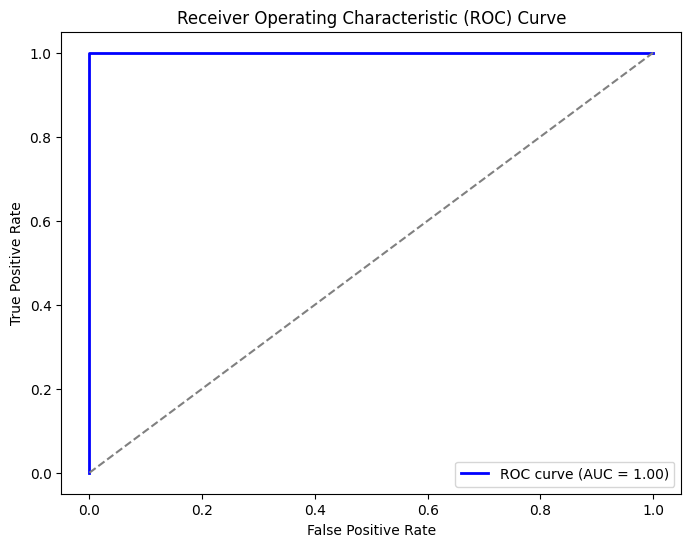

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(test_batch_labels, predictions)

# Compute ROC AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


1/1 [==============================] - 1s 917ms/step


<ipython-input-22-1c86256981e3>:10: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(img1, img2, multichannel=True)


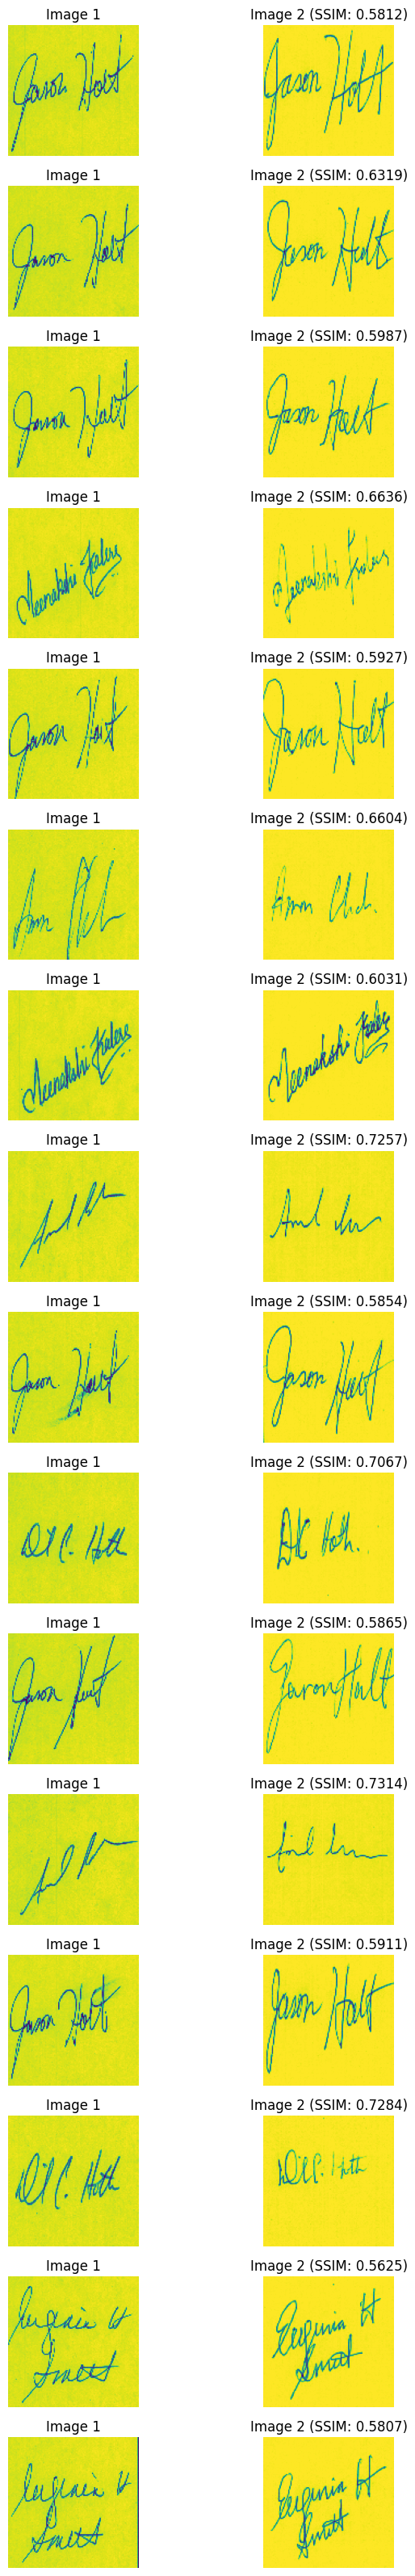

Average SSIM score: 0.7041726674819179


In [22]:
def display_genuine_forged_with_ssim(model, test_batch_generator, num_pairs=16):
    test_batch_inputs, test_batch_labels = next(test_batch_generator)
    predictions = model.predict(test_batch_inputs)
    fig, axes = plt.subplots(num_pairs, 2, figsize=(8, 2*num_pairs))

    genuine_forged_pairs = [(test_batch_inputs[0][i], test_batch_inputs[1][i], test_batch_labels[i]) for i in range(len(test_batch_labels)) if test_batch_labels[i] == 0]

    for i in range(num_pairs):
        img1, img2, label = genuine_forged_pairs[i]
        ssim_score = ssim(img1, img2, multichannel=True)

        axes[i, 0].imshow(img1)
        axes[i, 0].set_title(f"Image 1")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(img2)
        axes[i, 1].set_title(f"Image 2 (SSIM: {ssim_score:.4f})")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

        # Calculate average SSIM score
    average_ssim = np.mean(ssim_scores)
    print("Average SSIM score:", average_ssim)

# Call the function to display genuine-forged image pairs with SSIM scores
display_genuine_forged_with_ssim(model, test_batch_generator)



In [20]:
# Print paths of all images in the test set
for orig_group, forg_group in zip(orig_test, forg_test):
    print("Originals:")
    for img_path in orig_group:
        print(img_path)
    print("Forged:")
    for img_path in forg_group:
        print(img_path)


Originals:
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_1.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_10.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_11.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_12.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_13.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_14.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_15.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_16.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_17.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_18.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_19.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_2.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_20.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/or

In [21]:
# predictions, and labels
print("Predictions:")
print(predictions)
print("Ground Truth Labels:")
print(test_batch_labels)

Predictions:
[[0.47036216]
 [0.3633472 ]
 [0.37240377]
 [0.39599115]
 [0.4306043 ]
 [0.38020357]
 [0.43706486]
 [0.33834735]
 [0.50731325]
 [0.42796335]
 [0.40062118]
 [0.2860246 ]
 [0.37480548]
 [0.49713388]
 [0.5038304 ]
 [0.4053866 ]
 [0.12215119]
 [0.05876417]
 [0.08613605]
 [0.09552026]
 [0.06964841]
 [0.07330404]
 [0.051846  ]
 [0.06493992]
 [0.06130903]
 [0.06704684]
 [0.05791638]
 [0.10479573]
 [0.12412557]
 [0.0947867 ]
 [0.11442812]
 [0.13291207]]
Ground Truth Labels:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
